BitcoinHeistRansomwareAddressDataset Data Set
https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset

Nima Shafiei Rezvani Nezhad - nima.shafieirezvani@studio.unibo.it


Install  libraries

In [1]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 15.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=a346fedf564ab862fadbd80c96a9ad0191128291ee3d22cb8bea93cec0dfef74
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import required libraries

In [65]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
findspark.init()
from pyspark.sql import SparkSession

from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover, OneHotEncoder
from pyspark.sql.functions import col, udf, regexp_replace, isnull, isnan, when, count
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

from sklearn.model_selection import train_test_split, GridSearchCV
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes

from sklearn.pipeline import Pipeline
from pyspark.ml.pipeline import Pipeline

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-19"
os.environ["SPARK_HOME"] = 'C:\\Users\\Nima_S_H\\Desktop\\BDAVM\\spark'
findspark.init()

Initialize default configs using SparkSession

In [3]:
spark = SparkSession.builder.master("local").appName("BitcoinHeistData").config("spark.executor.memory", "1gb").getOrCreate()

In [4]:
sc = spark.sparkContext

Load dataset from local machine as a csv file

In [5]:
df = spark.read.csv('BitcoinHeistData.csv', header = 'True',inferSchema='True')

Display top 20 rows

In [6]:
df.show()

+--------------------+----+---+------+-------------------+-----+------+---------+--------+--------------------+
|             address|year|day|length|             weight|count|looped|neighbors|  income|               label|
+--------------------+----+---+------+-------------------+-----+------+---------+--------+--------------------+
|111K8kZAEnJg245r2...|2017| 11|    18|0.00833333333333333|    1|     0|        2|1.0005E8|     princetonCerber|
|1123pJv8jzeFQaCV4...|2016|132|    44|      2.44140625E-4|    1|     0|        1|   1.0E8|      princetonLocky|
|112536im7hy6wtKbp...|2016|246|     0|                1.0|    1|     0|        2|   2.0E8|     princetonCerber|
|1126eDRw2wqSkWosj...|2016|322|    72|         0.00390625|    1|     0|        2|  7.12E7|     princetonCerber|
|1129TSjKtx65E35Gi...|2016|238|   144| 0.0728484071989931|  456|     0|        1|   2.0E8|      princetonLocky|
|112AmFATxzhuSpvtz...|2016| 96|   144| 0.0846139993386755| 2821|     0|        1|   5.0E7|      princeto

Display the shape of DataSet

In [45]:
print((df.count(), len(df.columns)))

(665173, 10)


Check null values from dataframe


In [49]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-------+----+---+------+------+-----+------+---------+------+-----+
|address|year|day|length|weight|count|looped|neighbors|income|label|
+-------+----+---+------+------+-----+------+---------+------+-----+
|      0|   0|  0|     0|     0|    0|     0|        0|     0|    0|
+-------+----+---+------+------+-----+------+---------+------+-----+



Draw Corrolation matrix over DataSet

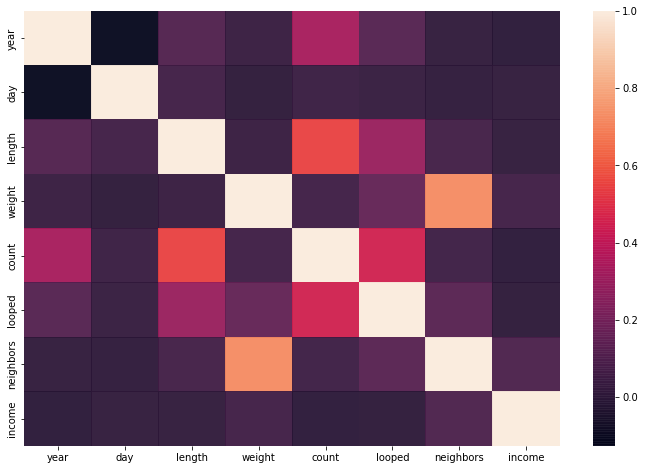

In [17]:
pandasDF = df.toPandas()
corr_test = pandasDF.corr()

plt.figure(figsize = (12,8))
sns.heatmap(corr_test,alpha=0.95)

<BarContainer object of 2 artists>

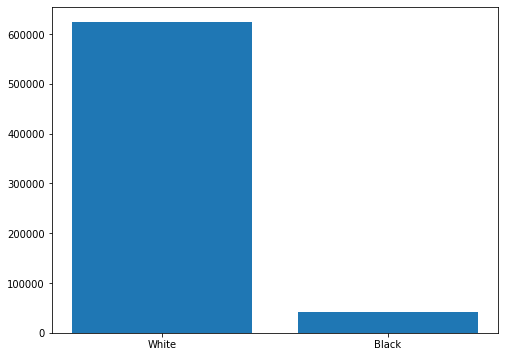

In [18]:
label_white = []
label_black = []
for element in df.collect():
  if element['label'] == 'white':
      label_white.append(element['label'])
  else:
      label_black.append(element['label'])

x_ax = ['White','Black']
y_ax = [len(label_white),len(label_black)]

plt.figure(figsize = (8,6))
plt.bar(x_ax,y_ax)

There are a lot of different unique malware types, but in a holistic view, the label can be viewed as 'white' (not associated with malware) or not (associated with malware). The value_counts(normalize=True) returns the normalized values for each unique element in the series, and it shows that ~98.58% of the dataset is labeled white, while the remaining 1.42% is not white. This menas that approximately 2,875,284 of 2,916,697 instances are white while 41,413 instances are not. Most of the addresses are white. The dataset is quite skewed, and is prone to errors because the dataset will very likely overfit the algorithm.


In [19]:
df.select("label").rdd.flatMap(lambda x: x).countByValue()

defaultdict(int,
            {'princetonCerber': 9223,
             'princetonLocky': 6625,
             'montrealCryptoLocker': 9315,
             'montrealCryptXXX': 2419,
             'paduaCryptoWall': 12390,
             'montrealWannaCry': 28,
             'montrealDMALockerv3': 354,
             'montrealCryptoTorLocker2015': 55,
             'montrealSamSam': 62,
             'montrealFlyper': 9,
             'montrealNoobCrypt': 483,
             'montrealDMALocker': 251,
             'montrealGlobe': 32,
             'montrealEDA2': 6,
             'paduaKeRanger': 10,
             'montrealVenusLocker': 7,
             'montrealXTPLocker': 8,
             'paduaJigsaw': 2,
             'montrealGlobev3': 34,
             'montrealJigSaw': 4,
             'montrealXLockerv5.0': 7,
             'montrealXLocker': 1,
             'montrealRazy': 13,
             'montrealCryptConsole': 7,
             'montrealGlobeImposter': 55,
             'montrealSam': 1,
             'mon

Show how the data is distributed.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

(30000000.0, 49964398238996.0)

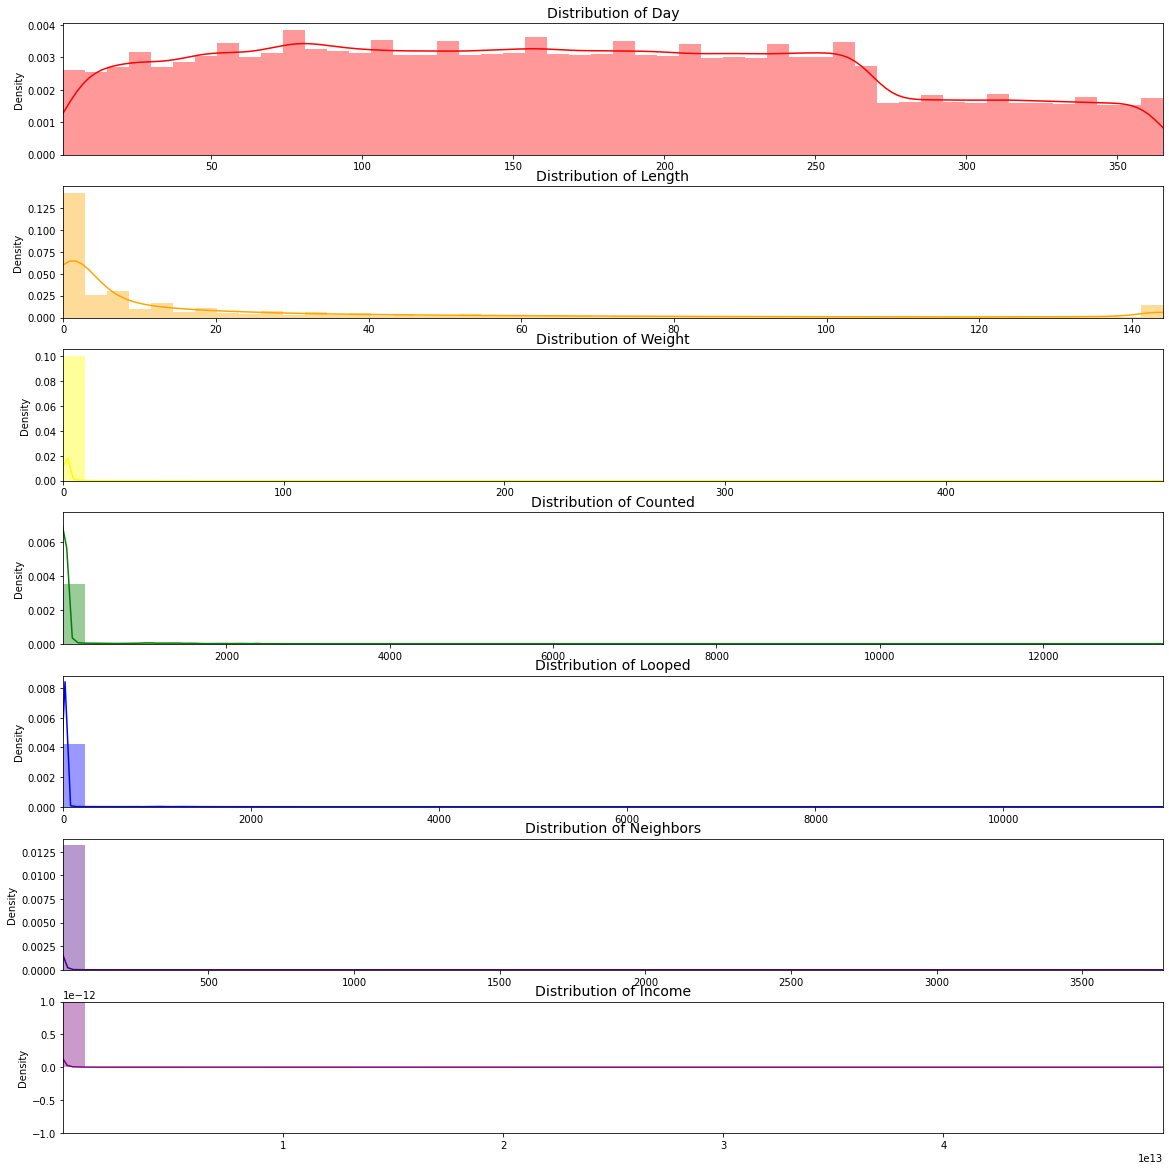

In [20]:
fig, ax = plt.subplots(7, 1,figsize=(16,16))
fig.tight_layout()

day_val = df.select("day").rdd.flatMap(lambda x: x).collect()
length_val = df.select("length").rdd.flatMap(lambda x: x).collect()
weight_val = df.select("weight").rdd.flatMap(lambda x: x).collect()
counted_val = df.select("count").rdd.flatMap(lambda x: x).collect()
looped_val = df.select("looped").rdd.flatMap(lambda x: x).collect()
neighbors_val = df.select("neighbors").rdd.flatMap(lambda x: x).collect()
income_val = df.select("income").rdd.flatMap(lambda x: x).collect()

sns.distplot(day_val, ax=ax[0], color='red')
ax[0].set_title('Distribution of Day', fontsize=14)
ax[0].set_xlim([min(day_val), max(day_val)])

sns.distplot(length_val, ax=ax[1],color='orange')
ax[1].set_title('Distribution of Length', fontsize=14)
ax[1].set_xlim([min(length_val), max(length_val)])

sns.distplot(weight_val, ax=ax[2],color='yellow')
ax[2].set_title('Distribution of Weight', fontsize=14)
ax[2].set_xlim([min(weight_val), max(weight_val)])

sns.distplot(counted_val, ax=ax[3],color='green')
ax[3].set_title('Distribution of Counted', fontsize=14)
ax[3].set_xlim([min(counted_val), max(counted_val)])

sns.distplot(looped_val, ax=ax[4],color='blue')
ax[4].set_title('Distribution of Looped', fontsize=14)
ax[4].set_xlim([min(looped_val), max(looped_val)])

sns.distplot(neighbors_val, ax=ax[5],color='indigo')
ax[5].set_title('Distribution of Neighbors', fontsize=14)
ax[5].set_xlim([min(neighbors_val), max(neighbors_val)])

sns.distplot(income_val, ax=ax[6],color='purple')
ax[6].set_title('Distribution of Income', fontsize=14)
ax[6].set_xlim([min(income_val), max(income_val)])

Encode column of Label to a column of Label numeric

In [21]:
indexer = StringIndexer(inputCol='label', outputCol='label_numeric').fit(df)
train_df = indexer.transform(df)

In [22]:
train_df.show()

+--------------------+----+---+------+-------------------+-----+------+---------+--------+--------------------+-------------+
|             address|year|day|length|             weight|count|looped|neighbors|  income|               label|label_numeric|
+--------------------+----+---+------+-------------------+-----+------+---------+--------+--------------------+-------------+
|111K8kZAEnJg245r2...|2017| 11|    18|0.00833333333333333|    1|     0|        2|1.0005E8|     princetonCerber|          3.0|
|1123pJv8jzeFQaCV4...|2016|132|    44|      2.44140625E-4|    1|     0|        1|   1.0E8|      princetonLocky|          4.0|
|112536im7hy6wtKbp...|2016|246|     0|                1.0|    1|     0|        2|   2.0E8|     princetonCerber|          3.0|
|1126eDRw2wqSkWosj...|2016|322|    72|         0.00390625|    1|     0|        2|  7.12E7|     princetonCerber|          3.0|
|1129TSjKtx65E35Gi...|2016|238|   144| 0.0728484071989931|  456|     0|        1|   2.0E8|      princetonLocky|       

Drop unnecessary columns

In [23]:
train_df = train_df.drop('address', 'year', 'day', 'label')

Display dataset after droping

In [24]:
train_df.show()

+------+-------------------+-----+------+---------+--------+-------------+
|length|             weight|count|looped|neighbors|  income|label_numeric|
+------+-------------------+-----+------+---------+--------+-------------+
|    18|0.00833333333333333|    1|     0|        2|1.0005E8|          3.0|
|    44|      2.44140625E-4|    1|     0|        1|   1.0E8|          4.0|
|     0|                1.0|    1|     0|        2|   2.0E8|          3.0|
|    72|         0.00390625|    1|     0|        2|  7.12E7|          3.0|
|   144| 0.0728484071989931|  456|     0|        1|   2.0E8|          4.0|
|   144| 0.0846139993386755| 2821|     0|        1|   5.0E7|          4.0|
|   142| 0.0020885186101272|  881|     0|        2|   1.0E8|          3.0|
|    78|         0.00390625|    1|     0|        2|1.0099E8|          3.0|
|   144|    2.3028283088657| 4220|     0|        2|   8.0E7|          3.0|
|   112|3.72529029846191E-9|    1|     0|        1|   5.0E7|          4.0|
|     4|0.007142857142857

Split data for training and testing

In [25]:
(trainingData, testData) = train_df.randomSplit([0.8, 0.2], seed = 11)

In [26]:
trainingData.show()

+------+-------------------+-----+------+---------+-----------+-------------+
|length|             weight|count|looped|neighbors|     income|label_numeric|
+------+-------------------+-----+------+---------+-----------+-------------+
|     0|0.00170648464163823|    1|     0|        1|3.0706548E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|3.2359742E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|3.4161816E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|3.5676176E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|3.6033835E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|4.4506409E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|4.5042808E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|4.9963347E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|5.0085656E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1|5.3286347E7| 

In [27]:
testData.show()

+------+-------------------+-----+------+---------+------------+-------------+
|length|             weight|count|looped|neighbors|      income|label_numeric|
+------+-------------------+-----+------+---------+------------+-------------+
|     0|0.00170648464163823|    1|     0|        1| 3.7398308E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 4.0591767E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 5.3966622E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 5.7374651E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 5.8050484E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 5.9661308E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 6.2540819E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 6.6509888E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 8.0874746E7|          0.0|
|     0|0.00170648464163823|    1|     0|        1| 

In [76]:
inputCols = trainingData.columns[0: len (trainingData.columns) - 1]

vecAssembler = VectorAssembler(inputCols = inputCols, outputCol = "features").setHandleInvalid("skip")

In [75]:
vecTrainDF = vecAssembler.transform(trainingData)
vecTrainDF.select ("features").show(5, False)

+-------------------------------------------------+
|features                                         |
+-------------------------------------------------+
|[0.0,0.00170648464163823,1.0,0.0,1.0,3.0706548E7]|
|[0.0,0.00170648464163823,1.0,0.0,1.0,3.2359742E7]|
|[0.0,0.00170648464163823,1.0,0.0,1.0,3.4161816E7]|
|[0.0,0.00170648464163823,1.0,0.0,1.0,3.5676176E7]|
|[0.0,0.00170648464163823,1.0,0.0,1.0,3.6033835E7]|
+-------------------------------------------------+
only showing top 5 rows



Compute summary statistics by fitting the StandardScaler and Normalize each feature to have unit standard deviation.

In [30]:
stdScaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [54]:
scalerModel = stdScaler.fit(vecTrainDF)

scaledDataDF = scalerModel.transform(vecTrainDF)
scaledDataDF.select ("scaledFeatures").show(5, False)

+--------------------------------------------------------------------------------------------+
|scaledFeatures                                                                              |
+--------------------------------------------------------------------------------------------+
|[0.0,9.12216506480011E-4,0.002210946917406408,0.0,0.06264231319368924,1.0693774213066418E-4]|
|[0.0,9.12216506480011E-4,0.002210946917406408,0.0,0.06264231319368924,1.1269510807306713E-4]|
|[0.0,9.12216506480011E-4,0.002210946917406408,0.0,0.06264231319368924,1.1897095922743246E-4]|
|[0.0,9.12216506480011E-4,0.002210946917406408,0.0,0.06264231319368924,1.2424482586893812E-4]|
|[0.0,9.12216506480011E-4,0.002210946917406408,0.0,0.06264231319368924,1.2549039882988155E-4]|
+--------------------------------------------------------------------------------------------+
only showing top 5 rows



### Modelling

In [59]:
evaluator = MulticlassClassificationEvaluator(labelCol='label_numeric', predictionCol="prediction", metricName="accuracy")

LogisticRegression

In [66]:

lr = LogisticRegression(maxIter=5, regParam=0.3, elasticNetParam=0.1, featuresCol="scaledFeatures", family = "Multinomial", labelCol='label_numeric')

pipeline_lr = Pipeline(stages=[vecAssembler, stdScaler, lr])
pipelineModel_lr = pipeline_lr.fit(trainingData)

In [67]:
predDF_lr = pipelineModel_lr.transform(testData)

In [68]:
lr_accuracy = evaluator.evaluate(predDF_lr)
print("Accuracy of LogisticRegression is = %g"%(lr_accuracy))
print("Test Error of LogisticRegression = %g "%(1.0 - lr_accuracy))

Accuracy of LogisticRegression is = 0.937544
Test Error of LogisticRegression = 0.0624559 


RandomForestClassifier

In [69]:

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol='label_numeric', \
                            featuresCol="scaledFeatures", \
                            numTrees=50)

pipeline_rf = Pipeline(stages=[vecAssembler, stdScaler, rf])
pipelineModel_rf = pipeline_rf.fit(trainingData)

In [70]:
predDF_rf = pipelineModel_rf.transform (testData)

In [71]:
rf_accuracy = evaluator.evaluate(predDF_rf)
print("Accuracy of Random Tree is = %g"%(rf_accuracy))
print("Error of Random Tree is = %g "%(1.0 - rf_accuracy))

Accuracy of Random Tree is = 0.940555
Error of Random Tree is = 0.059445 


NaiveBayes

In [77]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol='label_numeric')

pipeline_nb = Pipeline(stages=[vecAssembler, stdScaler, nb])
pipelineModel_nb = pipeline_nb.fit(trainingData)

In [78]:
predDF_nb = pipelineModel_nb.transform(testData)

In [79]:
nb_accuracy = evaluator.evaluate(predDF_nb)
print("Accuracy of Random Tree is = %g"%(nb_accuracy))
print("Error of Random Tree is = %g "%(1.0 - nb_accuracy))

Accuracy of Random Tree is = 0.385698
Error of Random Tree is = 0.614302 
